In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config import *
from N_ranking_utils import *
from sklearn.metrics import mean_squared_error

/opt/conda/envs/Base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1870, 5)


/tmp/ipykernel_230/2810498585.py:26: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(m, x='loss ela', y='loss transformer',hue='best algorithm', palette=color_palette, alpha=1)


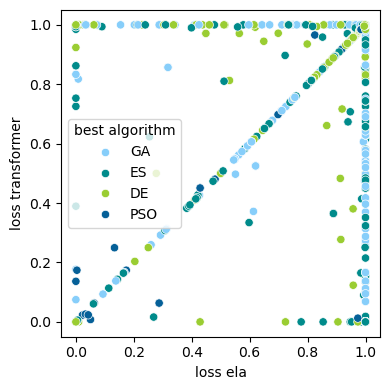

In [60]:
all_merged=[]
dimension=3
budget=50
algorithms='DE-GA-ES-PSO'
#algorithms='PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12'
alg_data=pd.read_csv(f'new_data/algorithm_performance/random_no_constants_{dimension}d_{algorithms}_column_normalized_score.csv')
alg_data=alg_data.query('budget==@budget').pivot(index='f',columns='algorithm_name',values='algorithm_rank').idxmin(axis=1).to_frame()
alg_data.columns=['best algorithm']
for fold in range(0,10):
    p=pd.read_csv(f'transformer_results_random_no_constants_no_param_tune/performance_prediction/{algorithms}_random_no_constants_dim_{dimension}_samples_50_fold_{fold}_budget_{budget}_n_heads_2_n_layers_1_d_model_100_d_k_30_d_v_30_aggregations_mean/test_transoptys_predictions.csv', index_col=0)
    #p.columns=[c.replace("PSO8","PSO5").replace("PSO10","PSO6") for c in p.columns]
    true=p[list(filter(lambda x: x.startswith("true_"), p.columns))]
    transformer=p[list(filter(lambda x: not x.startswith("true_"), p.columns))]
    
    ela=pd.read_csv(f'new_data/results_transformer_random_no_constants_no_param_tune/dim_{dimension}_samples_50d_{algorithms}_budget_{budget}_fold_{fold}_ela_predictions.csv',index_col=0)
    
    transformer.columns=[c.replace("pred_","") for c in transformer.columns]
    true.columns=[c.replace("true_","") for c in true.columns]
    ela_loss=calculate_loss(true,ela.loc[true.index],False).rename(columns={'score':'loss'})
    transformer_loss=calculate_loss(true,transformer.loc[true.index],False).rename(columns={'score':'loss'})
    merged=ela_loss.merge(transformer_loss, left_on='index', right_on='index', suffixes=[' ela',' transformer']).assign(fold=fold)
    all_merged+=[merged]
plt.figure(figsize=(4,4))
m=pd.concat(all_merged).merge(alg_data,left_on='index', right_index=True)
print(m.shape)
sns.scatterplot(m, x='loss ela', y='loss transformer',hue='best algorithm', palette=color_palette, alpha=1)
plt.tight_layout()
plt.savefig(f'figures/scatterplot_{algorithms}_dim_{dimension}_budget_{budget}.pdf')


In [67]:
all_scores=[]
for dim in [3,10]:
    for algorithm_portfolio in [ 'DE-GA-ES-PSO','PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12']:
        print(dim, algorithm_portfolio )
        df=pd.concat([pd.read_csv(f'new_data/results_transformer_random_no_constants_no_param_tune/dim_{dim}_samples_50d_{algorithm_portfolio}_budget_{budget}.csv', index_col=0) for budget in [10,30,50]])
        df=df.query('test_benchmark=="test" and model!="ELA"')[['budget','model','value','score','fold']]
        df['score']=df['score'].apply(lambda x: x if x!='Misrankings score' else 'PRE')

        ela_preds=calculate_all_ela_scores(dim, algorithm_portfolio)
        ela_preds=ela_preds.melt(id_vars=['fold','budget'], value_vars=['PRE','MSE','Loss'], var_name='score').assign(model='ELA')[['budget','model','value','score','fold']]
        print(ela_preds.shape)
        df=pd.concat([df,ela_preds])
        all_scores+=[df.assign(dimension=dim, algorithm_portfolio=algorithm_portfolio if algorithm_portfolio=="DE-GA-ES-PSO" else "PSO configurations")]
all_scores=pd.concat(all_scores)
transformer_minus_ela=[]
t=all_scores.set_index(['algorithm_portfolio','dimension','fold','score','model','budget'])
for algorithm_portfolio in ['DE-GA-ES-PSO','PSO configurations']:
    for dimension in [3,10]:
        for fold in range(0,10):
            for budget in [10,30,50]:
                s=t.loc[algorithm_portfolio, dimension, fold, 'Loss', 'ELA', budget] - t.loc[algorithm_portfolio, dimension, fold, 'Loss', 'transformer', budget]
                transformer_minus_ela+= [(algorithm_portfolio, dimension, fold, 'Loss', budget,float(s))]
transformer_minus_ela=pd.DataFrame(transformer_minus_ela, columns=['algorithm_portfolio','dimension','fold','score','budget','value'])
transformer_minus_ela.query('score=="Loss"').groupby(['dimension','algorithm_portfolio'])['value'].mean()

3 DE-GA-ES-PSO
(90, 5)
3 PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12
(90, 5)
10 DE-GA-ES-PSO
(90, 5)
10 PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12
(90, 5)


/tmp/ipykernel_230/1500872315.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  transformer_minus_ela+= [(algorithm_portfolio, dimension, fold, 'Loss', budget,float(s))]


dimension  algorithm_portfolio
3          DE-GA-ES-PSO           0.026219
           PSO configurations     0.025591
10         DE-GA-ES-PSO           0.006559
           PSO configurations     0.025798
Name: value, dtype: float64

3 DE-GA-ES-PSO


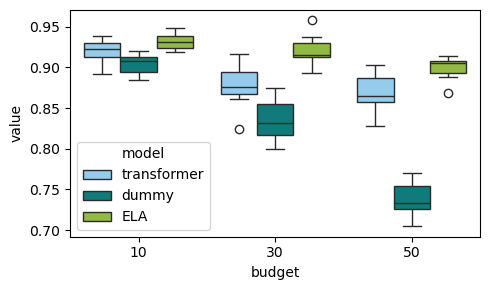

10 DE-GA-ES-PSO


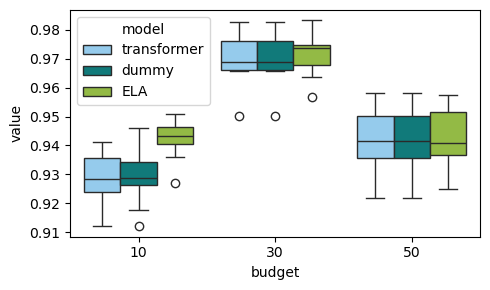

3 PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12


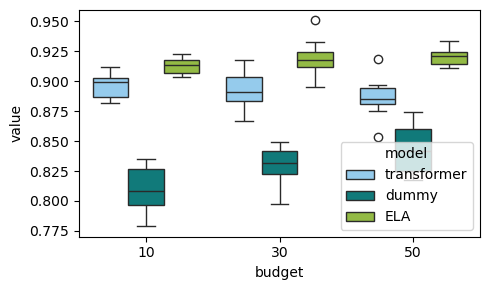

10 PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12


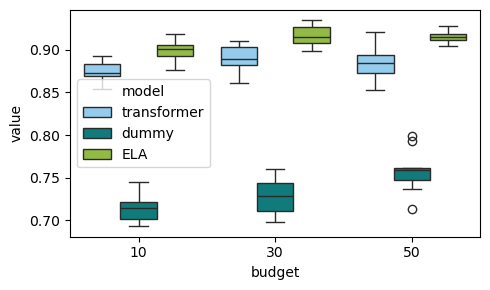

In [66]:

for algorithm_portfolio in ['DE-GA-ES-PSO', 'PSO1-PSO2-PSO3-PSO4-PSO5-PSO6-PSO7-PSO8-PSO9-PSO10-PSO11-PSO12']:
    for dim in [3,10]:
        print(dim, algorithm_portfolio )
        df=pd.concat([pd.read_csv(f'new_data/results_transformer_random_no_constants_no_param_tune/dim_{dim}_samples_50d_{algorithm_portfolio}_budget_{budget}.csv', index_col=0) for budget in [10,30,50]])
        df=df.query('test_benchmark=="test" and score=="Loss"')[['budget','model','value','score','fold']]
        '''df['score']=df['score'].apply(lambda x: x if x!='Misrankings score' else 'PRE')

        ela_preds=calculate_all_ela_scores(dim, algorithm_portfolio)
        ela_preds=ela_preds.melt(id_vars=['fold','budget'], value_vars=['PRE','MSE'], var_name='score').assign(model='ELA')[['budget','model','value','score','fold']]
        print(ela_preds.shape)
        df=pd.concat([df,ela_preds])'''

        plt.figure(figsize=(5,3))
        ax=sns.boxplot(df, x='budget', y='value', hue='model', palette=color_palette[:3])
        #ax.set_ylabel('loss')
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
        plt.tight_layout()
        plt.savefig(f'figures/transformer_results_{algorithm_portfolio}_dim_{dim}_samples_50.pdf')
        plt.show()
